# Predicting Material Properties of Transparent Conductors

# Section 1: Introduction

### I. Context

This project was a Kaggle Competition called Nomad2018 Predicting Transparent Conductors: https://www.kaggle.com/c/nomad2018-predict-transparent-conductors/overview. The project description describes why transparent conductors (particularly Al, Ga, In sesquioxides) are important:<br>
<br>
"Innovative materials design is needed to tackle some of the most important health, environmental, energy, social, and economic challenges of this century. In particular, improving the properties of materials that are intrinsically connected to the generation and utilization of energy is crucial if we are to mitigate environmental damage due to a growing global demand. Transparent conductors are an important class of compounds that are both electrically conductive and have a low absorption in the visible range, which are typically competing properties. A combination of both of these characteristics is key for the operation of a variety of technological devices such as photovoltaic cells, light-emitting diodes for flat-panel displays, transistors, sensors, touch screens, and lasers. However, only a small number of compounds are currently known to display both transparency and conductivity suitable enough to be used as transparent conducting materials. <br>
<br>
Aluminum (Al), gallium (Ga), indium (In) sesquioxides are some of the most promising transparent conductors because of a combination of both large bandgap energies, which leads to optical transparency over the visible range, and high conductivities. These materials are also chemically stable and relatively inexpensive to produce. Alloying of these binary compounds in ternary or quaternary mixtures could enable the design of a new material at a specific composition with improved properties over what is current possible." <br>
<br>
Density Functional Theory (DFT) is a computational materials modelling technique that relies on quantum mechanics to predict electronic structures (and other properties). This can be an effective way to screen promising materials before spending time and effort to do so experimentally. Despite the usefulness of DFT, it still be relatively time-consuming to predict material properties for thousands of materials. If machine learning can be applied to accurately predict desired material properties from DFT simulations, these models could potentially save time.

### II. Dataset

The dataset was obtained the Kaggle competition webpage. The data has been split into training and test folders which contains a CSV file with various features for each material as well as XYZ files (in separate subfolders) for each material that specifies the atomic coordinates in the unit cell. The CSV files contain numeric data only, while the XYZ files contain numeric and atomic labels (strings).

### III. Findings

- Incorporating mean Al-O, Ga-O and In-O distances (approximate for bond lengths) improved the model relative to non-inclusion. These features are quite crude and could do with more refinement - for example, create features that include the top 2-5 closest distances.
- The percentage of Al in the unit cell is strongly, and directly, related to the bandgap energy. Conversely, the percentage of In is strongly, but inversely, related to the bandgap energy.
- Mean Al-O and In-O both seemed to be directly related to the formation energy, with In-O having a relatively stronger effect.
- Random Forest Regressor was the algorithm that produced the lowest RMSLE score. The optimised hyperparameters included the number of trees in the forest and max_features. The winning model had 100 n_estimators and max_features of 'sqrt'.

### IV. This project

This project involved a multi-target regression problem that sought to predict two target variables. I have used various ML algorithms that are suited for multi-target predictions (i.e. Lasso, Ridge, Elastic Net and Random Forest regression). I have attempted to incorporate a crude measure of Al-O, Ga-O and In-O bond lengths by calculating the distance between atomic coordinates, using a cut-off to remove some 'long range' distances, and calculating the mean of the remaining distances. I set a time frame of 4 weeks to work on this project, and was relatively happy with the outcome but feel that I could look to incorpoate more domain knowledge (i.e. more meaningful features) in the future.

### V. Motivation

I am interested in computational materials science/engineering, so this project strongly appealed to me. Having domain knowledge enabled me to easily understand the context of the project and the meaning of the features in the dataset. My primary motivation for completing this project, however, was to develop my ML and Python skill sets. This was the first ML project I have completed, which was a great learning experience.

# Section 2: Library Imports and Helper Functions

In [113]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Matplotlib for visualisation
from matplotlib import pyplot as plt
from matplotlib import colors

# Seaborn for easier visualisation
import seaborn as sns
sns.set_style('darkgrid')

# Import Regular Expression Operators
import re

# Import math
import math

# Import os
import os

# Import statistics
import statistics

# Models from Scikit-Learn's library
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Import train_test_split and GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV

# Import make_pipeline
from sklearn.pipeline import make_pipeline

# Importing StandardScaler
from sklearn.preprocessing import StandardScaler

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Import NotFittedError
from sklearn.exceptions import NotFittedError

# Import mean_squared_log_error (win condition to minimise square root)
from sklearn.metrics import mean_squared_log_error

# Import Pickle
import pickle

## I. Unit cell volume calculation 

In [2]:
def UnitCellVolume(df):
    # Convert lattice angles from degrees to radians
    df['lattice_angle_alpha_rad'] = df['lattice_angle_alpha_degree']*(math.pi / 180)
    df['lattice_angle_beta_rad'] = df['lattice_angle_beta_degree']*(math.pi / 180)
    df['lattice_angle_gamma_rad'] = df['lattice_angle_gamma_degree']*(math.pi / 180)

    # Calculating elements of the metric matrix for each material
    a = df['lattice_vector_1_ang']**2
    b = df['lattice_vector_1_ang']*df['lattice_vector_2_ang']*np.cos(df['lattice_angle_gamma_rad'])
    c = df['lattice_vector_1_ang']*df['lattice_vector_3_ang']*np.cos(df['lattice_angle_beta_rad'])
    d = df['lattice_vector_2_ang']*df['lattice_vector_1_ang']*np.cos(df['lattice_angle_gamma_rad'])
    e = df['lattice_vector_2_ang']**2
    f = df['lattice_vector_1_ang']*df['lattice_vector_2_ang']*np.cos(df['lattice_angle_alpha_rad'])
    g = df['lattice_vector_3_ang']*df['lattice_vector_1_ang']*np.cos(df['lattice_angle_beta_rad'])
    h = df['lattice_vector_3_ang']*df['lattice_vector_2_ang']*np.cos(df['lattice_angle_alpha_rad'])
    i = df['lattice_vector_3_ang']**2

    # Store elements of metric matrix of each material in DataFrame: determinant_df
    determinant_df = pd.concat([a, b, c, d, e, f, g, h, i], axis=1, 
                                join='inner', 
                                keys=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'])

    # Volume of unit cell (length units in Angstrom)
    df['volume_unit_cell'] = (a*(e*i-f*h)-b*(d*i-f*g)+c*(d*h-e*g))**(1/2)

## II. Retrieve list of file locations from all subfolders of a directory

In [3]:
# Function getListOfFiles (iterates over subfolders of a directory)

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

## III. Calculate distance between two points in 3 dimensions

In [4]:
# Function to calculate the distance between two points in 3D: calculateDistance
def calculateDistance(x1,y1,z1,x2,y2,z2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)  
     return dist

## IV. Import Training DataFrame

In [5]:
# Loading 'train.csv' dataset as pandas DataFrame
df = pd.read_csv('train.csv', index_col=0) # uses 'id' column as the index

# Drop duplicates
df = df.drop_duplicates()
print(df.shape)

df = df.reset_index()

(2384, 13)


# Section 3: Exploratory Analysis

## I. Basic Information

In [6]:
# Shape of DataFrame (2400 observations, 11 features, 2 target variables)
print(df.shape)

# Checking data types
df.dtypes

(2384, 14)


id                              int64
spacegroup                      int64
number_of_total_atoms         float64
percent_atom_al               float64
percent_atom_ga               float64
percent_atom_in               float64
lattice_vector_1_ang          float64
lattice_vector_2_ang          float64
lattice_vector_3_ang          float64
lattice_angle_alpha_degree    float64
lattice_angle_beta_degree     float64
lattice_angle_gamma_degree    float64
formation_energy_ev_natom     float64
bandgap_energy_ev             float64
dtype: object

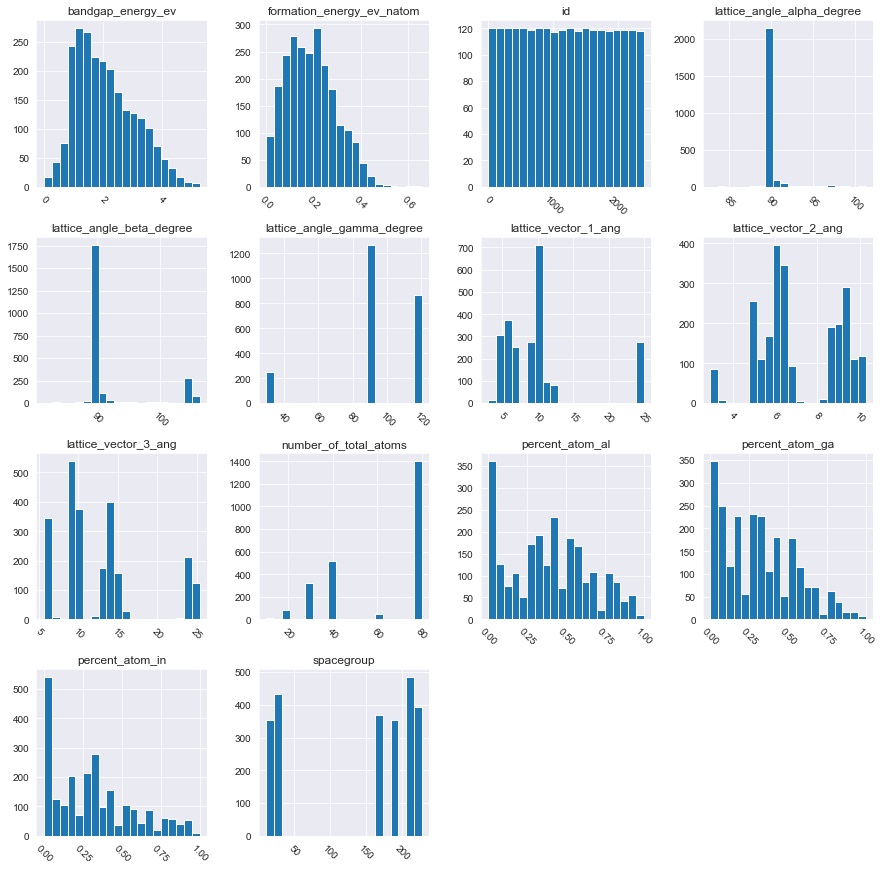

In [7]:
# Histograms
df.hist(figsize=(15,15), xrot=-45, bins=20)
plt.show()

In [8]:
# Summary statistics
df.describe()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
count,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000
mean,1197.725671,141.508809,61.744966,0.385950,0.309086,0.304962,10.031078,7.089715,12.607813,90.245316,92.391754,94.744228,0.188494,2.075985
std,693.195379,84.762307,22.557252,0.264828,0.233492,0.261346,5.651938,1.881922,5.460059,1.337972,5.293893,25.922469,0.103837,1.003604
min,1.000000,12.000000,10.000000,0.000000,0.000000,0.000000,3.037000,2.942300,5.672500,82.744100,81.641300,29.727400,0.000000,0.000100
25%,596.750000,33.000000,40.000000,0.166700,0.117200,0.062500,6.141775,5.834600,9.298000,89.999700,90.001000,89.998700,0.106175,1.279300
50%,1197.500000,194.000000,80.000000,0.375000,0.281200,0.250000,9.524350,6.385800,10.123400,90.001700,90.003600,90.000400,0.182800,1.907850
75%,1797.250000,206.000000,80.000000,0.583300,0.468800,0.468800,10.290900,9.090600,14.373100,90.006400,90.014325,119.998300,0.256700,2.760425
max,2400.000000,227.000000,80.000000,1.000000,1.000000,1.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500,0.657200,5.286100


## II. Correlations

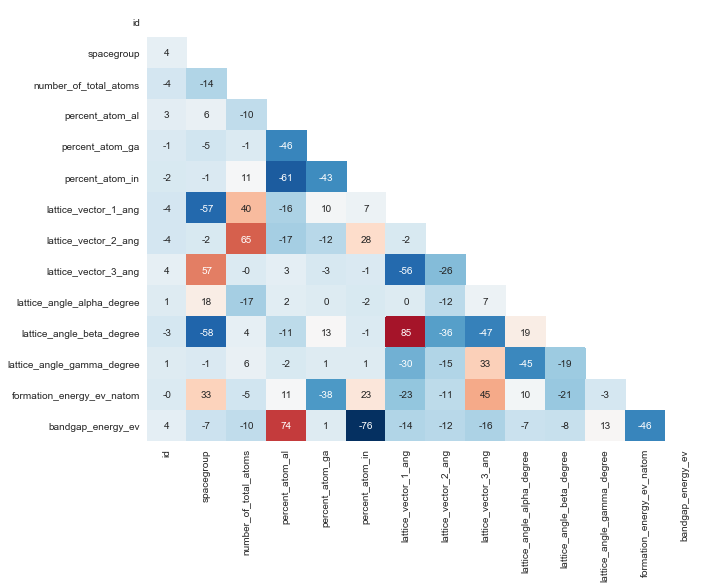

In [9]:
# Correlations
correlations = df.corr()

# Set figure style
sns.set_style('white')

# Set figsize 10 x 8
plt.figure(figsize=(10,8))

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

# Plot heatmap of correlations (percentages)
correlations = correlations * 100
sns.heatmap(correlations, 
            cmap='RdBu_r', 
            annot=True, 
            fmt='.0f', 
            mask=mask, 
            cbar=False)
plt.show()

# Section 4: Data Cleaning

## I. Looking at outliers

Violin plot for: id


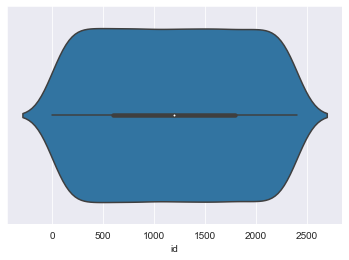

Violin plot for: spacegroup


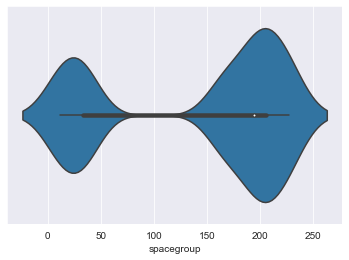

Violin plot for: number_of_total_atoms


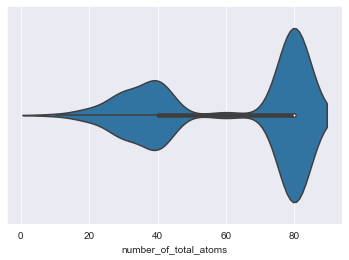

Violin plot for: percent_atom_al


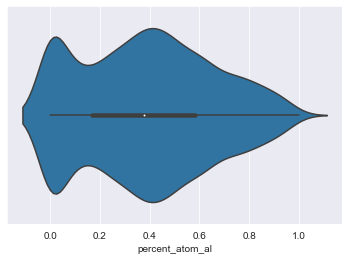

Violin plot for: percent_atom_ga


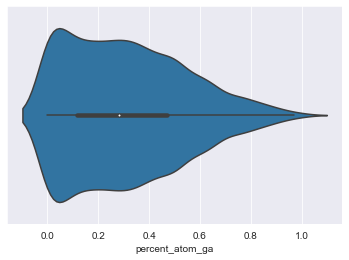

Violin plot for: percent_atom_in


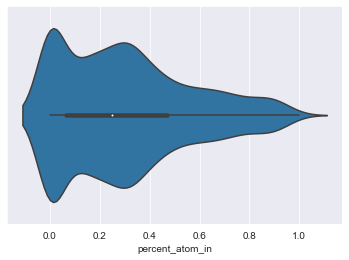

Violin plot for: lattice_vector_1_ang


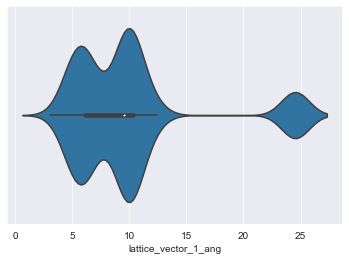

Violin plot for: lattice_vector_2_ang


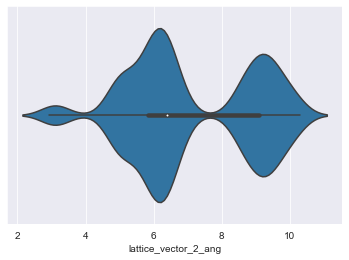

Violin plot for: lattice_vector_3_ang


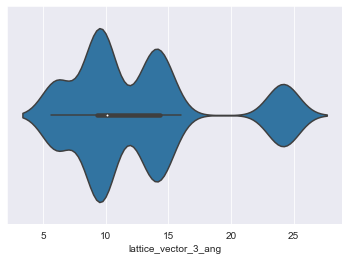

Violin plot for: lattice_angle_alpha_degree


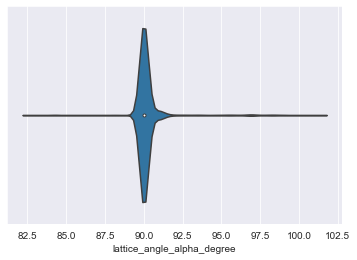

Violin plot for: lattice_angle_beta_degree


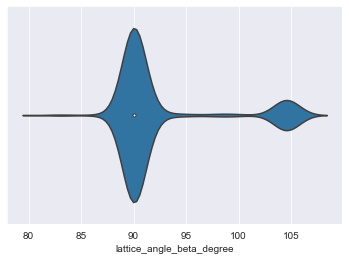

Violin plot for: lattice_angle_gamma_degree


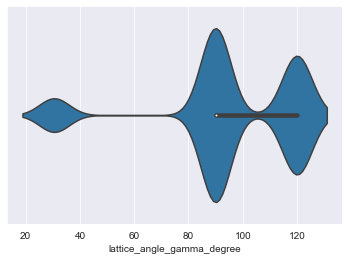

Violin plot for: formation_energy_ev_natom


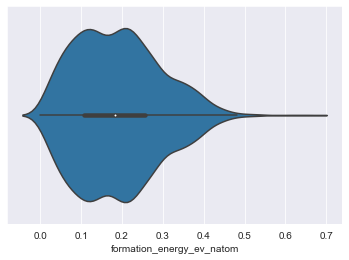

Violin plot for: bandgap_energy_ev


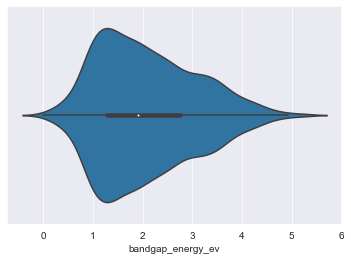

In [10]:
# Resetting Seaborn style to darkgrid
sns.set_style('darkgrid')

# Violin plots
for column in df:
    print('Violin plot for:', column)
    sns.violinplot(x=column, data=df)
    plt.show()

## II. Missing Data Check

In [145]:
df.isnull().sum()

id                            0
spacegroup                    0
number_of_total_atoms         0
percent_atom_al               0
percent_atom_ga               0
percent_atom_in               0
lattice_vector_1_ang          0
lattice_vector_2_ang          0
lattice_vector_3_ang          0
lattice_angle_alpha_degree    0
lattice_angle_beta_degree     0
lattice_angle_gamma_degree    0
formation_energy_ev_natom     0
bandgap_energy_ev             0
lattice_angle_alpha_rad       0
lattice_angle_beta_rad        0
lattice_angle_gamma_rad       0
volume_unit_cell              0
directory                     0
mean_al_o                     0
mean_ga_o                     0
mean_in_o                     0
dtype: int64

# Section 5: Feature Engineering

## I. Unit Cell Volume

The metric matrix of a unit cell can be used to determine the unit cell volume. Steps to calculate the unit cell volume:  
1. Convert lattice angles from degrees to radians.
<br> 
2. Calculate each element of the metric matrix for each material (stored as letters in the alphabet).
<br>
3. Calculate the unit cell volume as the square root of the determinant of the metric matrix.

In [12]:
UnitCellVolume(df)
df.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev,lattice_angle_alpha_rad,lattice_angle_beta_rad,lattice_angle_gamma_rad,volume_unit_cell
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,1.570842,1.570836,1.570826,781.052081
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,1.571121,1.570761,2.094439,782.500148
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,1.587705,1.590393,0.532648,391.227636
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,1.570601,1.571004,2.094425,293.377337
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,1.570727,1.570807,2.094208,944.713845


## II. Utilising Cartesian Coordinate Data

In addition to the main DataFrame, the Kaggle competition hosts provided cartesian coordinates of each atom of the DFT simulations to determine formation energy and bandgap energy. This information was stored in separate subfolders as XYZ files for each material.<br> 
<br> 
The greatest challenge I had in this project was working out how to incorporate this data.

In [13]:
# Main directory location for cartesian coordinate data for each material
nomad_train_dir = 'C:\\Users\\acmor\\Dropbox\\Machine Learning\\Elite Data Science\\Machine Learning Accelerator\\Capstone Project\\nomad\\train'

# Create a list of the location of each individual file
listOfFiles = getListOfFiles(nomad_train_dir)

# Create listOfFiles_df (unique location for each geometry.xyz file)
listOfFiles_df = pd.DataFrame(listOfFiles, columns=['directory'])

display(listOfFiles_df)

,directory
0,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1\distance.csv
1,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1\geometry.xyz
2,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\10\distance.csv
3,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\10\geometry.xyz
4,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\100\distance.csv
...,...
4795,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\997\geometry.xyz
4796,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\998\distance.csv
4797,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\998\geometry.xyz
4798,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\999\distance.csv


Encountered a problem here. The above code worked well before I created the distance.csv files. I have had to alter the problem to get a listOfFiles for geometry and for distance files.

In [14]:
# Create indexList from listOfFiles_df
indexList = list(range(len(listOfFiles_df)))

# Create evensList from indexList (distance.csv file locations)
evensList = [x for x in indexList if x % 2 == 0]

# Create oddList from indexList (geometry.xyz file locations)
oddsList = [x for x in indexList if x % 2 != 0]

In [15]:
# Create list of geometry.xyz files: listOfGeometryFiles
listOfGeometryFiles = []

for i in oddsList:
    temp = listOfFiles_df.iloc[i][0]
    listOfGeometryFiles.append(temp)
    
# Create DataFrame from listOfGeometryFiles: listOfGeometryFiles_df
listOfGeometryFiles_df = pd.DataFrame(listOfGeometryFiles, columns=['directory'])

In [16]:
# Create list of distance.csv files: listOfDistanceFiles
listOfDistanceFiles = []

for i in evensList:
    temp = listOfFiles_df.iloc[i][0]
    listOfDistanceFiles.append(temp)

# Create DataFrame from listOfGeometryFiles: listOfGeometryFiles_df
listOfDistanceFiles_df = pd.DataFrame(listOfDistanceFiles, columns=['directory'])

The directory for each material's geometry.xyz and distance.csv files has been stored in listOfGeometryFiles_df and listOfDistanceFiles_df, respectively. I want to create a material_id column for each DataFrame that matches the correct ID of the material (unlike the current index).

In [17]:
# Extracting material ID from the directory location in listOfGeometryFiles_df
material_id = []
for i in range(len(listOfGeometryFiles_df)):
    
    # Storing temporary text
    temp_text = listOfGeometryFiles_df.iloc[i][0]
    
    # Create new column in listOfFiles_df called material_id
    temp_material_str = temp_text.partition("C:\\Users\\acmor\\Dropbox\\Machine Learning\\Elite Data Science\\Machine Learning Accelerator\\Capstone Project\\nomad\\train\\")[2].partition("\\geometry.xyz")[0]
    temp_material_int = temp_material_str.split(" ")
    material_id.extend(temp_material_int)

# Create id column in listOfFiles_df that specifies the material's id
listOfGeometryFiles_df['id'] = material_id

# Display first 5 observations
listOfGeometryFiles_df.head(10)

,directory,id
0,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1\geometry.xyz,1
1,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\10\geometry.xyz,10
2,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\100\geometry.xyz,100
3,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1000\geometry.xyz,1000
4,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1001\geometry.xyz,1001
5,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1002\geometry.xyz,1002
6,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1003\geometry.xyz,1003
7,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1004\geometry.xyz,1004
8,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1005\geometry.xyz,1005
9,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1006\geometry.xyz,1006


In [18]:
# Extracting material ID from the directory location in listOfGeometryFiles_df
material_distance_id = []

for i in range(len(listOfDistanceFiles_df)):
    
    # Storing temporary text
    temp_text = listOfDistanceFiles_df.iloc[i][0]
    
    # Create new column in listOfFiles_df called material_id
    temp_material_str = temp_text.partition("C:\\Users\\acmor\\Dropbox\\Machine Learning\\Elite Data Science\\Machine Learning Accelerator\\Capstone Project\\nomad\\train\\")[2].partition("\\distance.csv")[0]
    temp_material_int = temp_material_str.split(" ")
    material_distance_id.extend(temp_material_int)

# Create id column in listOfFiles_df that specifies the material's id
listOfDistanceFiles_df['id'] = material_distance_id

# Display first 5 observations
listOfDistanceFiles_df.head(10)

,directory,id
0,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1\distance.csv,1
1,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\10\distance.csv,10
2,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\100\distance.csv,100
3,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1000\distance.csv,1000
4,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1001\distance.csv,1001
5,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1002\distance.csv,1002
6,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1003\distance.csv,1003
7,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1004\distance.csv,1004
8,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1005\distance.csv,1005
9,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\train\1006\distance.csv,1006


I want to create a dictionary that stores the cartesian coordinate data from the geometry.xyz file for each material. The directory column from listOfGeometryFiles_df will be the keys for the dictionary and the values will be the atom cartesian coordinate DataFrames.

In [19]:
# Create dictionary geometry_dict that stores geometry.xyz data for each material in the training set
geometry_dict = {}

# Store geometry.xyz file data in geometry_dict
for file in listOfGeometryFiles:
    temp = pd.read_csv(file, skiprows=6, header=None) # uses 'id' column as the index
    temp = temp[0].str.split(" ", expand=True)
    temp = temp.drop([0], axis=1)
    geometry_dict[file] = temp
    
# Renaming columns
for i in range(len(listOfGeometryFiles)):
    mapping = {geometry_dict[listOfGeometryFiles[i]].columns[0]:'x', 
               geometry_dict[listOfGeometryFiles[i]].columns[1]:'y',
               geometry_dict[listOfGeometryFiles[i]].columns[2]:'z',
               geometry_dict[listOfGeometryFiles[i]].columns[3]:'element'}
    geometry_dict[listOfGeometryFiles[i]].rename(columns=mapping, inplace=True)
    
# Convert numbers as strings to integers
for i in range(len(listOfGeometryFiles)):
    df_columns = ['x', 'y', 'z']
    for column in df_columns:
        geometry_dict[listOfGeometryFiles[i]][column] = pd.to_numeric(geometry_dict[listOfGeometryFiles[i]][column])

In [20]:
# An example of the geometry.xyz data
geometry_dict[listOfGeometryFiles[10]]

,x,y,z,element
0,-0.003825,0.005864,2.127660,In
1,5.358024,0.064764,2.137196,In
2,-0.016661,0.025541,9.267458,In
3,5.345187,0.084441,9.276994,In
4,-0.021847,0.033490,12.151937,Ga
5,5.340002,0.092390,12.161473,In
6,-0.009011,0.013813,5.012139,Ga
7,5.352838,0.072713,5.021675,In
8,2.651617,1.596098,6.888016,In
9,8.013466,1.654998,6.897552,Ga


Next objective: to calculate the distances between each (x,y,z) coordinate for each material. Store the closest distances in an attempt to 'best represent' bonds between atoms. Then calculate the approximate bond lengths using the atomic radii of each element.

Next, create a dictionary that stores the distance.csv data for each material. The keys will be the directory locations from listOfDistanceFiles_df and values will be DataFrames containing the distance.csv file data.

In [21]:
# Create dictionary geometry_dict that stores geometry.xyz data for each material in the training set
distance_dict = {}

# Store distance.csv file data in distance_dict
for file in listOfDistanceFiles:
    temp = pd.read_csv(file)
    distance_dict[file] = temp

In [22]:
# Dictionary to store X-O mean bond lengths with keys based on file directory

# Store average X-oxide bond distances in bond_length_dict (X = Al, Ga or In)
bondlength_dict = {}

for file in listOfDistanceFiles:
    
    # Empty bonding lists
    bond_al_o = []
    bond_ga_o = []
    bond_in_o = []
    
    # Calculate average bond distance in unit cell for Al-O, Ga-O and In-O bonds
    for x in range(len(distance_dict[file])):
        if (distance_dict[file]['element_1'].iloc[x] == 'Al') and (distance_dict[file]['element_2'].iloc[x] == 'O'):
            bond_al_o.append(distance_dict[file]['distance'].iloc[x])
            
        if (distance_dict[file]['element_1'].iloc[x] == 'O') and (distance_dict[file]['element_2'].iloc[x] == 'Al'):
            bond_al_o.append(distance_dict[file]['distance'].iloc[x])
           
        # Populating bond_ga_o
        if (distance_dict[file]['element_1'].iloc[x] == 'Ga') and (distance_dict[file]['element_2'].iloc[x] == 'O'):
            bond_ga_o.append(distance_dict[file]['distance'].iloc[x])
            
        if (distance_dict[file]['element_1'].iloc[x] == 'O') and (distance_dict[file]['element_2'].iloc[x] == 'Ga'):
            bond_ga_o.append(distance_dict[file]['distance'].iloc[x])
        
        # Populating bond_in_o
        if (distance_dict[file]['element_1'].iloc[x] == 'In') and (distance_dict[file]['element_2'].iloc[x] == 'O'):
            bond_in_o.append(distance_dict[file]['distance'].iloc[x])
            
        if (distance_dict[file]['element_1'].iloc[x] == 'O') and (distance_dict[file]['element_2'].iloc[x] == 'In'):
            bond_in_o.append(distance_dict[file]['distance'].iloc[x])
        
    # Bond length DataFrame
    bondlength_df = pd.DataFrame([])
        
    # Saving bond lengths to DataFrame
    bondlength_df['al_o_bond'] = pd.Series(bond_al_o, dtype='float64')
    bondlength_df['ga_o_bond'] = pd.Series(bond_ga_o, dtype='float64')
    bondlength_df['in_o_bond'] = pd.Series(bond_in_o, dtype='float64')

    # Saving bond_length_df to bond_length_dict
    bondlength_dict[file] = bondlength_df

Code immediately below does the following: 1. Convert strings in material_id to float; 2. Create list of material id's that aren't in the main DataFrame (df); 3. Convert id's not in the DataFrame back to strings; 4. Remove '.0' from the strings (created upon conversion to float); 4. Store directories of distance.csv files for material id's not in the main DataFrame; 5. Removes two cases that are in the main DataFrame that are captured from material id's 694 and 987 (i.e. 1694 and 1987).

In [23]:
# Convert string dtypes in material_id to float
material_id = [float(i) for i in material_id]

# Convert string dtypes in material_id to float
material_id = [float(i) for i in material_id]

# Create list of material id's that aren't in the main df
id_not_in_df = []

main_df_material_id = list(df['id'])

for i in material_id:
    if i not in main_df_material_id:
        id_not_in_df.append(i)
        
# Convert id_not_in_df back to string
id_not_in_df = [str(i) for i in id_not_in_df]

# Remove '.0' from strings
for i in range(len(id_not_in_df)):
    id_not_in_df[i] = id_not_in_df[i][:-2]

# Store directory of distance.csv files not in the main DataFrame (keys to distance_dict)
directory_not_in = []

for x in range(len(listOfDistanceFiles)):
    for i in id_not_in_df:
        if i in listOfDistanceFiles[x]:
            directory_not_in.append(listOfDistanceFiles[x])

# Need to drop 2 values from directory_not_in
directory_not_in.pop(6)
directory_not_in.pop(10)

'C:\\Users\\acmor\\Dropbox\\Machine Learning\\Elite Data Science\\Machine Learning Accelerator\\Capstone Project\\nomad\\train\\1987\\distance.csv'

In [24]:
# Remove material ids in id_not_in_df from listOfDistanceFiles_df 
for i in id_not_in_df:
    listOfDistanceFiles_df = listOfDistanceFiles_df[listOfDistanceFiles_df.id != i]

In [25]:
# Remove key value pairs from bondlength_dict with keys in directory_not_in
for file in directory_not_in:
    bondlength_dict.pop(file, None)

print(len(bondlength_dict))

2384


In [26]:
# Confirming lengths are the same
if (len(bondlength_dict) == len(df)) and (len(df) == len(listOfDistanceFiles_df)):
    print('They are all equal in length.')

They are all equal in length.


In [27]:
# Convert id column from listOfDistanceFiles_df to int from object (enables merge)
listOfDistanceFiles_df['id'] = listOfDistanceFiles_df['id'].astype(int)

# Merge df with listOfDistanceFiles_df on id column to create new DataFrame: df
df = pd.merge(df, listOfDistanceFiles_df, on="id")

In [28]:
# Remove material with index 2139 (id 2153) from df and bondlength_dict (causes unknown errors, was unable to solve in time)
bondlength_dict.pop(df['directory'][2139], None)
df = df[df.id != 2153]

The objective is to store the directory location matching the material ID in the main DataFrame. This will make it easier to correctly store average bond lengths in the right place of the main DataFrame.

In [53]:
# Calculate mean bond lengths and store in main DataFrame
al_o = []
ga_o = []
in_o = []

for i in df.index:
 
    # Filter out NaN from columns of bondlength_dict to calculate mean bond length
    filtered_al = bondlength_dict[df['directory'][i]]['al_o_bond'][bondlength_dict[df['directory'][i]]['al_o_bond'].notnull()]
    filtered_ga = bondlength_dict[df['directory'][i]]['ga_o_bond'][bondlength_dict[df['directory'][i]]['ga_o_bond'].notnull()]
    filtered_in = bondlength_dict[df['directory'][i]]['in_o_bond'][bondlength_dict[df['directory'][i]]['in_o_bond'].notnull()]
    
    # Calculate mean X-O mean bond lengths
    if len(filtered_al) != 0:
        al_o_length = statistics.mean(filtered_al)
    if len(filtered_al) == 0:
        al_o_length = 0
      
    if len(filtered_ga) != 0:
        ga_o_length = statistics.mean(filtered_ga)
    
    if len(filtered_ga) == 0:
        ga_o_length = 0    
    
    if len(filtered_in) != 0:
        in_o_length = statistics.mean(filtered_in)
    
    if len(filtered_in) == 0:
        in_o_length = 0
    
    # Append to empty X-O list
    al_o.append(al_o_length)
    ga_o.append(ga_o_length)
    in_o.append(in_o_length)
    
    # Status update
    print(i, 'has been completed.')

# Add mean X-O list to main DataFrame
df['mean_al_o'] = al_o
df['mean_ga_o'] = ga_o
df['mean_in_o'] = in_o

0 has been completed.
1 has been completed.
2 has been completed.
3 has been completed.
4 has been completed.
5 has been completed.
6 has been completed.
7 has been completed.
8 has been completed.
9 has been completed.
10 has been completed.
11 has been completed.
12 has been completed.
13 has been completed.
14 has been completed.
15 has been completed.
16 has been completed.
17 has been completed.
18 has been completed.
19 has been completed.
20 has been completed.
21 has been completed.
22 has been completed.
23 has been completed.
24 has been completed.
25 has been completed.
26 has been completed.
27 has been completed.
28 has been completed.
29 has been completed.
30 has been completed.
31 has been completed.
32 has been completed.
33 has been completed.
34 has been completed.
35 has been completed.
36 has been completed.
37 has been completed.
38 has been completed.
39 has been completed.
40 has been completed.
41 has been completed.
42 has been completed.
43 has been completed

374 has been completed.
375 has been completed.
376 has been completed.
377 has been completed.
378 has been completed.
379 has been completed.
380 has been completed.
381 has been completed.
382 has been completed.
383 has been completed.
384 has been completed.
385 has been completed.
386 has been completed.
387 has been completed.
388 has been completed.
389 has been completed.
390 has been completed.
391 has been completed.
392 has been completed.
393 has been completed.
394 has been completed.
395 has been completed.
396 has been completed.
397 has been completed.
398 has been completed.
399 has been completed.
400 has been completed.
401 has been completed.
402 has been completed.
403 has been completed.
404 has been completed.
405 has been completed.
406 has been completed.
407 has been completed.
408 has been completed.
409 has been completed.
410 has been completed.
411 has been completed.
412 has been completed.
413 has been completed.
414 has been completed.
415 has been com

723 has been completed.
724 has been completed.
725 has been completed.
726 has been completed.
727 has been completed.
728 has been completed.
729 has been completed.
730 has been completed.
731 has been completed.
732 has been completed.
733 has been completed.
734 has been completed.
735 has been completed.
736 has been completed.
737 has been completed.
738 has been completed.
739 has been completed.
740 has been completed.
741 has been completed.
742 has been completed.
743 has been completed.
744 has been completed.
745 has been completed.
746 has been completed.
747 has been completed.
748 has been completed.
749 has been completed.
750 has been completed.
751 has been completed.
752 has been completed.
753 has been completed.
754 has been completed.
755 has been completed.
756 has been completed.
757 has been completed.
758 has been completed.
759 has been completed.
760 has been completed.
761 has been completed.
762 has been completed.
763 has been completed.
764 has been com

1073 has been completed.
1074 has been completed.
1075 has been completed.
1076 has been completed.
1077 has been completed.
1078 has been completed.
1079 has been completed.
1080 has been completed.
1081 has been completed.
1082 has been completed.
1083 has been completed.
1084 has been completed.
1085 has been completed.
1086 has been completed.
1087 has been completed.
1088 has been completed.
1089 has been completed.
1090 has been completed.
1091 has been completed.
1092 has been completed.
1093 has been completed.
1094 has been completed.
1095 has been completed.
1096 has been completed.
1097 has been completed.
1098 has been completed.
1099 has been completed.
1100 has been completed.
1101 has been completed.
1102 has been completed.
1103 has been completed.
1104 has been completed.
1105 has been completed.
1106 has been completed.
1107 has been completed.
1108 has been completed.
1109 has been completed.
1110 has been completed.
1111 has been completed.
1112 has been completed.


1414 has been completed.
1415 has been completed.
1416 has been completed.
1417 has been completed.
1418 has been completed.
1419 has been completed.
1420 has been completed.
1421 has been completed.
1422 has been completed.
1423 has been completed.
1424 has been completed.
1425 has been completed.
1426 has been completed.
1427 has been completed.
1428 has been completed.
1429 has been completed.
1430 has been completed.
1431 has been completed.
1432 has been completed.
1433 has been completed.
1434 has been completed.
1435 has been completed.
1436 has been completed.
1437 has been completed.
1438 has been completed.
1439 has been completed.
1440 has been completed.
1441 has been completed.
1442 has been completed.
1443 has been completed.
1444 has been completed.
1445 has been completed.
1446 has been completed.
1447 has been completed.
1448 has been completed.
1449 has been completed.
1450 has been completed.
1451 has been completed.
1452 has been completed.
1453 has been completed.


1784 has been completed.
1785 has been completed.
1786 has been completed.
1787 has been completed.
1788 has been completed.
1789 has been completed.
1790 has been completed.
1791 has been completed.
1792 has been completed.
1793 has been completed.
1794 has been completed.
1795 has been completed.
1796 has been completed.
1797 has been completed.
1798 has been completed.
1799 has been completed.
1800 has been completed.
1801 has been completed.
1802 has been completed.
1803 has been completed.
1804 has been completed.
1805 has been completed.
1806 has been completed.
1807 has been completed.
1808 has been completed.
1809 has been completed.
1810 has been completed.
1811 has been completed.
1812 has been completed.
1813 has been completed.
1814 has been completed.
1815 has been completed.
1816 has been completed.
1817 has been completed.
1818 has been completed.
1819 has been completed.
1820 has been completed.
1821 has been completed.
1822 has been completed.
1823 has been completed.


2117 has been completed.
2118 has been completed.
2119 has been completed.
2120 has been completed.
2121 has been completed.
2122 has been completed.
2123 has been completed.
2124 has been completed.
2125 has been completed.
2126 has been completed.
2127 has been completed.
2128 has been completed.
2129 has been completed.
2130 has been completed.
2131 has been completed.
2132 has been completed.
2133 has been completed.
2134 has been completed.
2135 has been completed.
2136 has been completed.
2137 has been completed.
2138 has been completed.
2140 has been completed.
2141 has been completed.
2142 has been completed.
2143 has been completed.
2144 has been completed.
2145 has been completed.
2146 has been completed.
2147 has been completed.
2148 has been completed.
2149 has been completed.
2150 has been completed.
2151 has been completed.
2152 has been completed.
2153 has been completed.
2154 has been completed.
2155 has been completed.
2156 has been completed.
2157 has been completed.


## III. Preparing the Analytical Base Table

In [55]:
# Finalising ABT
abt = df.copy()

# Dropping redundant columns from abt
to_drop = ['id', 'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
          'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree',
          'lattice_angle_alpha_rad', 'lattice_angle_beta_rad', 'lattice_angle_gamma_rad', 'directory']

abt.drop(to_drop, axis=1, inplace=True)

In [56]:
abt.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,formation_energy_ev_natom,bandgap_energy_ev,volume_unit_cell,mean_al_o,mean_ga_o,mean_in_o
0,33,80.0,0.6250,0.3750,0.000,0.0680,3.4387,781.052081,2.888391,2.828780,0.000000
1,194,80.0,0.6250,0.3750,0.000,0.2490,2.9210,782.500148,2.848708,2.904361,0.000000
2,227,40.0,0.8125,0.1875,0.000,0.1821,2.7438,391.227636,2.759155,2.635141,0.000000
3,167,30.0,0.7500,0.0000,0.250,0.2172,3.3492,293.377337,2.016801,0.000000,2.007684
4,194,80.0,0.0000,0.6250,0.375,0.0505,1.3793,944.713845,0.000000,3.548541,3.399509


In [57]:
# Save analytical base table
abt.to_csv('analytical_base_table.csv', index=None)

## IV. Back to Exploratory Analysis

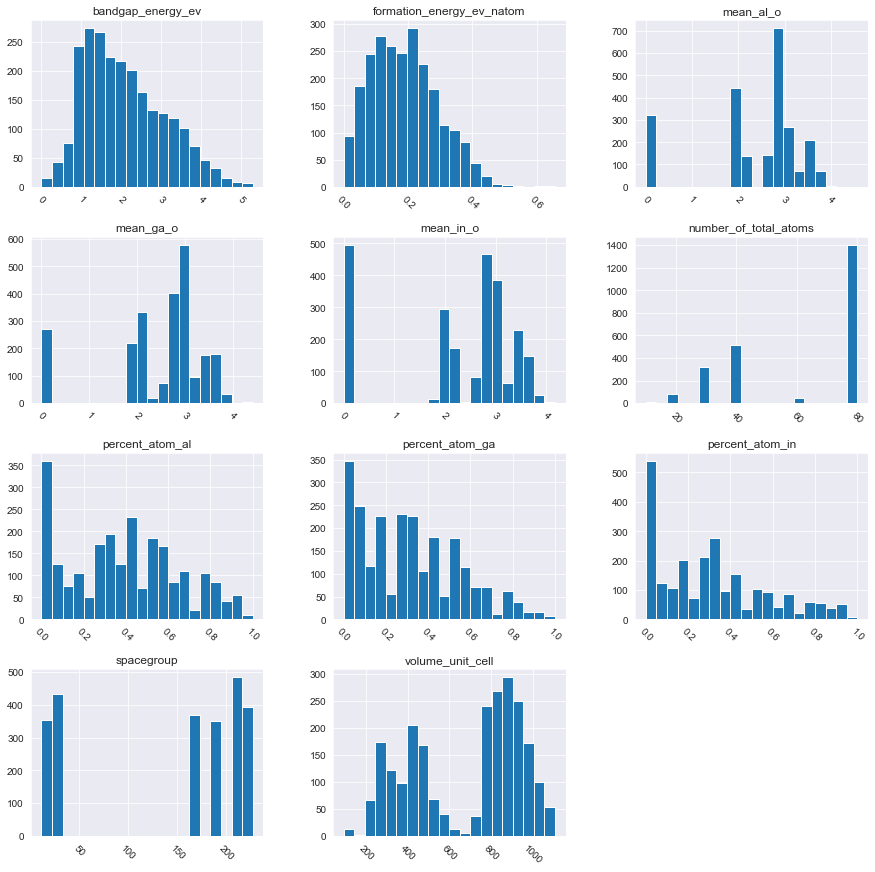

In [146]:
# Histograms
abt.hist(figsize=(15,15), xrot=-45, bins=20)
plt.show()

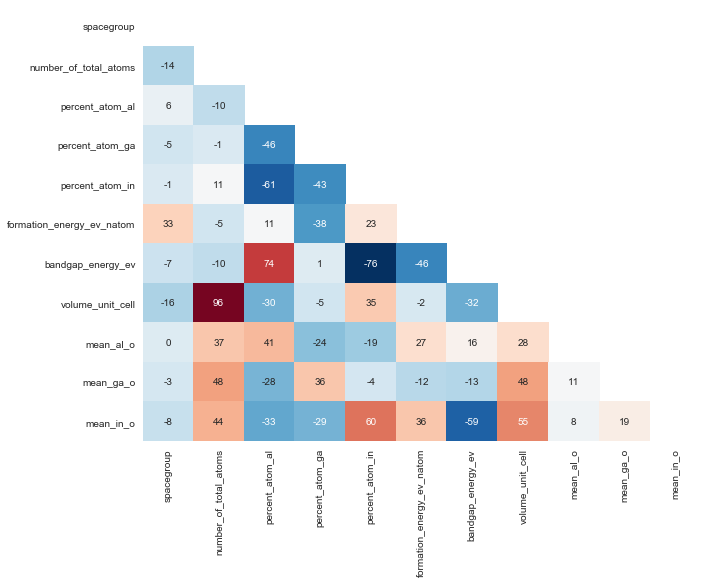

In [58]:
# Correlations
correlations = abt.corr()

# Set figure style
sns.set_style('white')

# Set figsize 10 x 8
plt.figure(figsize=(10,8))

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = 1

# Plot heatmap of correlations (percentages)
correlations = correlations * 100
sns.heatmap(correlations, 
            cmap='RdBu_r', 
            annot=True, 
            fmt='.0f', 
            mask=mask, 
            cbar=False)
plt.show()

# Section 6: Preparing Test Dataset

In [90]:
# Loading 'train.csv' dataset as pandas DataFrame
unseen_df  = pd.read_csv('test.csv', index_col=0)
print(unseen_df.shape)

unseen_df = unseen_df.reset_index()

# Kaggle competition expects 600 predictions for 600 observations, so no duplicates dropped.

(600, 11)


In [91]:
# Display first 5 observations - note: bandgap and formation energy columns missing.
unseen_df.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001


In [92]:
# Calculate unit cell volume for the unseen data
UnitCellVolume(unseen_df)
unseen_df.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,lattice_angle_alpha_rad,lattice_angle_beta_rad,lattice_angle_gamma_rad,volume_unit_cell
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006,1.570791,1.570802,1.570807,915.347470
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015,1.570863,1.570836,1.570823,767.917987
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014,1.570622,1.570987,2.094420,289.624657
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002,1.570788,1.812666,1.570800,818.126772
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001,1.570796,1.825490,1.570798,923.997043


In [93]:
# Test directory location
nomad_test_dir = 'C:\\Users\\acmor\\Dropbox\\Machine Learning\\Elite Data Science\\Machine Learning Accelerator\\Capstone Project\\nomad\\test'

# Create a list of the location of each individual file
testListFiles = getListOfFiles(nomad_test_dir)

# Create listOfFiles_df (unique location for each geometry.xyz file)
testListFiles_df = pd.DataFrame(testListFiles, columns=['directory'])

display(testListFiles_df)

,directory
0,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\1\distance.csv
1,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\1\geometry.xyz
2,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\10\distance.csv
3,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\10\geometry.xyz
4,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\100\distance.csv
...,...
1195,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\97\geometry.xyz
1196,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\98\distance.csv
1197,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\98\geometry.xyz
1198,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\99\distance.csv


In [94]:
# Create indexList from listOfFiles_df
indexList = list(range(len(testListFiles_df)))

# Create evensList from indexList (distance.csv file locations)
evensList = [x for x in indexList if x % 2 == 0]

# Create oddList from indexList (geometry.xyz file locations)
oddsList = [x for x in indexList if x % 2 != 0]

In [95]:
# Create list of geometry.xyz files: listOfGeometryFiles
testGeometryFiles = []

for i in oddsList:
    temp = testListFiles_df.iloc[i][0]
    testGeometryFiles.append(temp)
    
# Create DataFrame from listOfGeometryFiles: listOfGeometryFiles_df
testGeometryFiles_df = pd.DataFrame(testGeometryFiles, columns=['directory'])

# Create list of distance.csv files: listOfDistanceFiles
testDistanceFiles = []

for i in evensList:
    temp = testListFiles_df.iloc[i][0]
    testDistanceFiles.append(temp)

# Create DataFrame from listOfGeometryFiles: listOfGeometryFiles_df
testDistanceFiles_df = pd.DataFrame(testDistanceFiles, columns=['directory'])

In [96]:
# Extracting material ID from the directory location in listOfGeometryFiles_df
testMaterial_id = []

for i in range(len(testDistanceFiles_df)):
    
    # Storing temporary text
    temp_text = testDistanceFiles_df.iloc[i][0]
    
    # Create new column in listOfFiles_df called material_id
    temp_material_str = temp_text.partition("C:\\Users\\acmor\\Dropbox\\Machine Learning\\Elite Data Science\\Machine Learning Accelerator\\Capstone Project\\nomad\\test\\")[2].partition("\\distance.csv")[0]
    temp_material_int = temp_material_str.split(" ")
    testMaterial_id.extend(temp_material_int)

# Create id column in listOfFiles_df that specifies the material's id
testDistanceFiles_df['id'] = testMaterial_id

# Display first 5 observations of testDistanceFiles_df
testDistanceFiles_df.head()

,directory,id
0,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\1\distance.csv,1
1,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\10\distance.csv,10
2,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\100\distance.csv,100
3,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\101\distance.csv,101
4,C:\Users\acmor\Dropbox\Machine Learning\Elite Data Science\Machine Learning Accelerator\Capstone Project\nomad\test\102\distance.csv,102


In [97]:
# Create dictionary that stores distance.csv files for each material of the test set
test_distance_dict = {}

# Store distance.csv file data in distance_dict
for file in testDistanceFiles:
    temp = pd.read_csv(file)
    test_distance_dict[file] = temp

In [98]:
# Dictionary to store X-O mean bond lengths with keys based on file directory

# Store average X-oxide bond distances in bond_length_dict (X = Al, Ga or In)
test_bond_dict = {}

for file in testDistanceFiles:
    
    # Empty bonding lists
    bond_al_o = []
    bond_ga_o = []
    bond_in_o = []
    
    # Calculate average bond distance in unit cell for Al-O, Ga-O and In-O bonds
    for x in range(len(test_distance_dict[file])):
        if (test_distance_dict[file]['element_1'].iloc[x] == 'Al') and (test_distance_dict[file]['element_2'].iloc[x] == 'O'):
            bond_al_o.append(test_distance_dict[file]['distance'].iloc[x])
            
        if (test_distance_dict[file]['element_1'].iloc[x] == 'O') and (test_distance_dict[file]['element_2'].iloc[x] == 'Al'):
            bond_al_o.append(test_distance_dict[file]['distance'].iloc[x])
           
        # Populating bond_ga_o
        if (test_distance_dict[file]['element_1'].iloc[x] == 'Ga') and (test_distance_dict[file]['element_2'].iloc[x] == 'O'):
            bond_ga_o.append(test_distance_dict[file]['distance'].iloc[x])
            
        if (test_distance_dict[file]['element_1'].iloc[x] == 'O') and (test_distance_dict[file]['element_2'].iloc[x] == 'Ga'):
            bond_ga_o.append(test_distance_dict[file]['distance'].iloc[x])
        
        # Populating bond_in_o
        if (test_distance_dict[file]['element_1'].iloc[x] == 'In') and (test_distance_dict[file]['element_2'].iloc[x] == 'O'):
            bond_in_o.append(test_distance_dict[file]['distance'].iloc[x])
            
        if (test_distance_dict[file]['element_1'].iloc[x] == 'O') and (test_distance_dict[file]['element_2'].iloc[x] == 'In'):
            bond_in_o.append(test_distance_dict[file]['distance'].iloc[x])
        
    # Bond length DataFrame
    test_bond_df = pd.DataFrame([])
        
    # Saving bond lengths to DataFrame
    test_bond_df['al_o_bond'] = pd.Series(bond_al_o, dtype='float64')
    test_bond_df['ga_o_bond'] = pd.Series(bond_ga_o, dtype='float64')
    test_bond_df['in_o_bond'] = pd.Series(bond_in_o, dtype='float64')

    # Saving bond_length_df to bond_length_dict
    test_bond_dict[file] = test_bond_df

In [101]:
# Convert id column from testDistanceFiles_df to int from object (enables merge)
testDistanceFiles_df['id'] = testDistanceFiles_df['id'].astype(int)

# Merge df with listOfDistanceFiles_df on id column to create new DataFrame: df
unseen_df = pd.merge(unseen_df, testDistanceFiles_df, on="id")

In [103]:
# Calculate mean bond lengths and store in main DataFrame
test_al_o = []
test_ga_o = []
test_in_o = []

for i in unseen_df.index:
 
    # Filter out NaN from columns of bondlength_dict to calculate mean bond length
    test_filtered_al = test_bond_dict[unseen_df['directory'][i]]['al_o_bond'][test_bond_dict[unseen_df['directory'][i]]['al_o_bond'].notnull()]
    test_filtered_ga = test_bond_dict[unseen_df['directory'][i]]['ga_o_bond'][test_bond_dict[unseen_df['directory'][i]]['ga_o_bond'].notnull()]
    test_filtered_in = test_bond_dict[unseen_df['directory'][i]]['in_o_bond'][test_bond_dict[unseen_df['directory'][i]]['in_o_bond'].notnull()]
    
    # Calculate mean X-O mean bond lengths
    if len(test_filtered_al) != 0:
        al_o_length = statistics.mean(test_filtered_al)
        
    if len(test_filtered_al) == 0:
        al_o_length = 0
        
    if len(test_filtered_ga) != 0: 
        ga_o_length = statistics.mean(test_filtered_ga)
    
    if len(test_filtered_ga) == 0:
        ga_o_length = 0
        
    if len(test_filtered_in) != 0:
        in_o_length = statistics.mean(test_filtered_in)
    
    if len(test_filtered_in) == 0:
        in_o_length = 0
    
    # Append to empty X-O list
    test_al_o.append(al_o_length)
    test_ga_o.append(ga_o_length)
    test_in_o.append(in_o_length)
    
    # Status update
    print(i, 'has been completed.')

# Add mean X-O list to main DataFrame
unseen_df['mean_al_o'] = test_al_o
unseen_df['mean_ga_o'] = test_ga_o
unseen_df['mean_in_o'] = test_in_o

0 has been completed.
1 has been completed.
2 has been completed.
3 has been completed.
4 has been completed.
5 has been completed.
6 has been completed.
7 has been completed.
8 has been completed.
9 has been completed.
10 has been completed.
11 has been completed.
12 has been completed.
13 has been completed.
14 has been completed.
15 has been completed.
16 has been completed.
17 has been completed.
18 has been completed.
19 has been completed.
20 has been completed.
21 has been completed.
22 has been completed.
23 has been completed.
24 has been completed.
25 has been completed.
26 has been completed.
27 has been completed.
28 has been completed.
29 has been completed.
30 has been completed.
31 has been completed.
32 has been completed.
33 has been completed.
34 has been completed.
35 has been completed.
36 has been completed.
37 has been completed.
38 has been completed.
39 has been completed.
40 has been completed.
41 has been completed.
42 has been completed.
43 has been completed

363 has been completed.
364 has been completed.
365 has been completed.
366 has been completed.
367 has been completed.
368 has been completed.
369 has been completed.
370 has been completed.
371 has been completed.
372 has been completed.
373 has been completed.
374 has been completed.
375 has been completed.
376 has been completed.
377 has been completed.
378 has been completed.
379 has been completed.
380 has been completed.
381 has been completed.
382 has been completed.
383 has been completed.
384 has been completed.
385 has been completed.
386 has been completed.
387 has been completed.
388 has been completed.
389 has been completed.
390 has been completed.
391 has been completed.
392 has been completed.
393 has been completed.
394 has been completed.
395 has been completed.
396 has been completed.
397 has been completed.
398 has been completed.
399 has been completed.
400 has been completed.
401 has been completed.
402 has been completed.
403 has been completed.
404 has been com

In [ ]:
# Finalising test_df
test_abt = unseen_df.copy()

# Dropping redundant columns from abt
to_drop = ['id', 'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
          'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree',
          'lattice_angle_alpha_rad', 'lattice_angle_beta_rad', 'lattice_angle_gamma_rad', 'directory']

test_abt.drop(to_drop, axis=1, inplace=True)

# Display first 10 observations
test_abt.head(10)

In [111]:
# Save test_df
test_abt.to_csv('test_abt.csv', index=None)

# Section 7: Algorithm Selection

Algorithms selected:
- Lasso Regression
- Ridge Regression
- Elastic Net Regression
- Random Forest Regressor

Rationalisation for algorithms selected:
- Had to have been covered in the EDS course.
- Capable of handling multi-target regression.

Lasso Regression & Ridge Regression hyperparameters to tune:
- Learning rate (cover several orders of magnitude)

Elastic Net Regression hyperparameters to tune:
- Learning rate (several orders of magnitude)
- Mixed penalty parameter (e.g. L1 and L2 penalty split) - l1_ratio

Random Forest Regressor hyperparmeters to tune:
- Number of trees in the forest
- Number of features to consider when looking for best split (i.e. max_features)

# Section 8: Simultaneous Prediction of Target Variables

## I. Model Training

In [115]:
# Create object for target variables
target_y = ['formation_energy_ev_natom', 'bandgap_energy_ev']
y = abt[target_y]

# Create separate object for input features
X = abt.drop(target_y, axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2020)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1906 477 1906 477


In [116]:
# Create pipelines dictionary
pipelines1 = {
    'lasso': make_pipeline(StandardScaler(), 
                           Lasso(random_state=123)),
    'ridge': make_pipeline(StandardScaler(), 
                           Ridge(random_state=123)),
    'enet': make_pipeline(StandardScaler(), 
                          ElasticNet(random_state=123)),
    'rf': make_pipeline(StandardScaler(), 
                        RandomForestRegressor(random_state=123))
}

In [117]:
# Lasso hyperparameters
lasso_hyperparameters = {
    'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
}
    
# Ridge hyperparameters
ridge_hyperparameters = {
    'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]
}

# ElasticNet hyperparameters
enet_hyperparameters = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
}

# Create hyperparameters dictionary
hyperparameters = {
    'lasso': lasso_hyperparameters,
    'ridge': ridge_hyperparameters,
    'enet': enet_hyperparameters,
    'rf': rf_hyperparameters,
}

In [118]:
# Model hyperparameter tuning loop

# Create empty dictionary fitted_models1
fitted_models1 = {}

# Fitting models and tuning hyperparameters: 10-fold Cross Validation
for name, pipeline in pipelines1.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train and y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models
    fitted_models1[name] = model
    
    # Create update output: print '{name} has been fitted.'
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.


In [119]:
# Checking model types
for key, value in fitted_models1.items():
    print(key, type(value))

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>


In [120]:
# Verifying models have been fitted correctly
for name, model in fitted_models1.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.


In [121]:
# Display cross-validated training performance for each model
for name, model in fitted_models1.items():
    print(name, model.best_score_)

lasso 0.7791881697253826
ridge 0.7794850388577395
enet 0.7791835145200674
rf 0.9410546463522763


In [122]:
# Normalise y_test data (create new y_test DataFrame: y_test_df)
y_test_df = y_test.copy()
  
max_be = max(y_test_df['bandgap_energy_ev'])
min_be = min(y_test_df['bandgap_energy_ev'])
max_fe = max(y_test_df['formation_energy_ev_natom'])
min_fe = min(y_test_df['formation_energy_ev_natom'])

for i in y_test_df.index:
    y_test_df['formation_energy_ev_natom'][i] = (y_test_df['formation_energy_ev_natom'][i] - min_fe) / (max_fe - min_fe)
    y_test_df['bandgap_energy_ev'][i] = (y_test_df['bandgap_energy_ev'][i] - min_be) / (max_be - min_be)

In [123]:
# Performance of each model on test set
for name, model in fitted_models1.items():
    pred = model.predict(X_test)
    pred_df = pd.DataFrame(pred, columns=['fe', 'be'])
    
    max_be = max(pred_df['be'])
    min_be = min(pred_df['be'])
    max_fe = max(pred_df['fe'])
    min_fe = min(pred_df['fe'])
    
    for i in pred_df.index:
        pred_df['fe'][i] = (pred_df['fe'][i] - min_fe) / (max_fe - min_fe)
        pred_df['be'][i] = (pred_df['be'][i] - min_be) / (max_be - min_be)
    
    print(name)
    print('______')
    print('RMSLE:', np.sqrt(mean_squared_log_error( y_test_df, pred)))
    print()

lasso
______
RMSLE: 0.1442337953517523

ridge
______
RMSLE: 0.14616526464877475

enet
______
RMSLE: 0.14420895034831435

rf
______
RMSLE: 0.06325732642019753



lasso


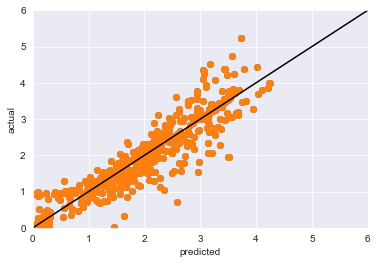

ridge


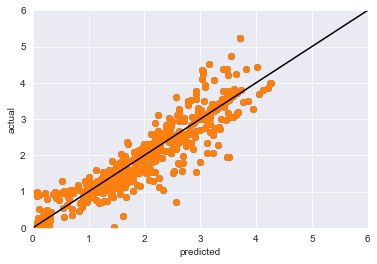

enet


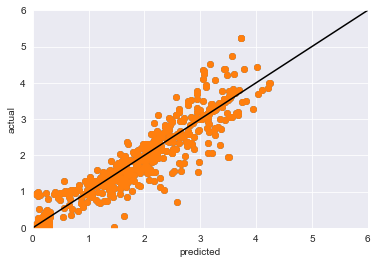

rf


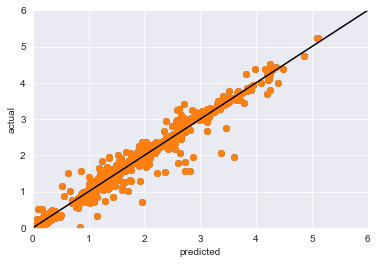

In [124]:
# Plotting model performance
for name, model in fitted_models1.items():
    pred = model.predict(X_test)
    print(name)
    # Scatter plot of actual vs. predicted
    plt.scatter(pred, y_test)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    
    plt.scatter(pred, y_test)
    plt.plot([0, 6], [0, 6], color = 'k')
    plt.xlim(0, 6)
    plt.ylim(0, 6)

    plt.show()

In [125]:
# Dispaly winning pipeline to check hyperparameters
fitted_models1['rf'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=123,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [126]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models1['rf'].best_estimator_, f)

## II. Predicting Unlabelled Test Data

In [127]:
# Predict formation and bandgap energies of unlabelled test dataset (test_abt)
predictions = fitted_models1['rf'].predict(test_abt)

In [141]:
# Create DataFrame for predictions: predictions_df
predictions_df = pd.DataFrame(predictions, columns=['formation_energy_ev_natom', 'bandgap_energy_ev'])

# Add 'id' column to predictions_df
list_id = range(1, 601)
predictions_df['id'] = list_id

In [143]:
display(predictions_df)

,formation_energy_ev_natom,bandgap_energy_ev,id
0,0.194637,1.567203,1
1,0.116019,3.681892,2
2,0.146248,3.514149,3
3,0.030284,3.044086,4
4,0.163103,1.562350,5
...,...,...,...
595,0.045726,1.340787,596
596,0.229877,0.971137,597
597,0.117488,0.937136,598
598,0.252401,2.243215,599


In [144]:
# Save predictions to predictions.csv
predictions_df.to_csv('predictions.csv', index=None)

I submitted my predictions DataFrame on the Kaggle competition website and received a RMSLE of 0.06837. This placed me 235th of 811.

# Section 9: Insights and Analysis

### Key findings and results

- Random Forest Regressor significantly outperformed Lasso, Ridge and Elastic Net Regression.
- Percent Al and percent In have a strong direct and inverse effect on bandgap energy, respectively.
- The mean Al-O, Ga-O and In-O features, while crude, helped improve the model.

### What did I personally learn?

- How to import data from multiple subdirectories (e.g. geometry.xyz files) & how to store these DataFrames in a dictionary.
- Initially I stored the geometry.xyz files in a dictionary with keys based on the range of material ID's from the training DataFrame. This became a problem when I wanted to create new features and add them to the correct rows of the main DataFrame. The solution was to use each material file location as the key to the dictionary storing the geometry.xyz files.
- I couldn't use GradientBoostingRegressor to perform simultaneous multi-target regression in the same way that I could with the algorithms that I used in this project. I would like to further investigate this. Some questions: does this algorithm have this capability at all? I would like to explore XGBoost too.
- Fitting the model took approximately 1% of my time on this project. 99% of it was spent on trying to utilise the geometry.xyz files and incorporate new features. Domain knowledge + Python programming skills = very important.

### How would I improve the project if I have more time/resources?

- Spend more time on feature engineering - read some research papers and try to incorporate more meangingful features rather than the crude mean X-O features in this project.

### Useful Resources

- DataCamp for general python programming knowledge/skills acquisition.
- All EDS projects
- Stack Overflow Questions - this resource was absolutely critical in troubleshooting almost every problem I encountered.

# Section 10: Appendix

The code below was used to calculate and store in a dictionary the distances between each atom of the geometry.xyz data. It took a very long time to run, probably owing to the number of calculations. To save time, I decided to save this data for each material in a distance.csv file which could then be read into this notebook. Additionally, duplicate calculations were removed and a cut off (25th percentile) was used to exclude relatively long-range distances (this cut-off was arbitrary).

## I. Distance Files for Training Set

In [ ]:
#distance_dict = {}

# Create desired dataframe using one geometry.xyz file
#for x in range(len(listOfGeometryFiles_df)):
    
    # Empty lists
#    calculated_distance = []
#    element1 = []
#    element2 = []
    
#    for i in geometry_dict[listOfGeometryFiles[x]].index:
#        for j in geometry_dict[listOfGeometryFiles[x]].index:
#            if i>j:
                # Point coordinates
#                x1 = geometry_dict[listOfGeometryFiles[x]].iloc[i][0]
#                y1 = geometry_dict[listOfGeometryFiles[x]].iloc[i][1]
#                z1 = geometry_dict[listOfGeometryFiles[x]].iloc[i][2]
#                x2 = geometry_dict[listOfGeometryFiles[x]].iloc[j][0]
#                y2 = geometry_dict[listOfGeometryFiles[x]].iloc[j][1]
#                z2 = geometry_dict[listOfGeometryFiles[x]].iloc[j][2]
    
                # Calculate distance for point coordinates
#                distance = calculateDistance(x1, y1, z1, x2, y2, z2)
    
                # Append distance and element information to lists
#                calculated_distance.append(distance)
#                element1.append(geometry_dict[listOfGeometryFiles[x]].iloc[i][3])
#                element2.append(geometry_dict[listOfGeometryFiles[x]].iloc[j][3])

                # Create DataFrame to store distance information
#                distance_df = pd.DataFrame([])

#                distance_df['distance'] = calculated_distance
#                distance_df['element_1'] = element1
#                distance_df['element_2'] = element2
            
                # Store distance_df in distance_dict
#                distance_dict[x] = distance_df
#            else:
#                pass

In [ ]:
# Remove rows with distance less than the 25th percentile
    # Cut-off is arbitrary, but intends to remove 'long-range' non-bonded atom distances

#for i in range(len(listOfGeometryFiles_df)):
    # Store indexes for distances greater than 25th percentile
#    indexNames = distance_dict[i][distance_dict[i]['distance'] > math.floor(distance_dict[i]['distance'].quantile(.25))].index
    
    # Update distance DataFrames stored in distance_dict
#    distance_dict[i].drop(indexNames, inplace=True)

In [ ]:
# Remove duplicates based on 'distance' column

#for i in range(len(listOfGeometryFiles_df)):
#    distance_dict[i].drop_duplicates(subset='distance', inplace=True)

In [ ]:
# Save directory locations excluding 'geometry.xyz'

#save_path = []

#for i in range(len(listOfGeometryFiles_df)):
#    path_to_save = listOfGeometryFiles_df['directory'][i]
    
#    if path_to_save.endswith('geometry.xyz'):
#        path_to_save = path_to_save[:-12]
        
#        save_path.append(path_to_save)

In [ ]:
# Save distance DataFrames to 'distance.csv' & store same folder as geometry.xyz for each material

#for i in range(len(listOfGeometryFiles_df)):
#    path = save_path[i]
    
#    distance_dict[i].to_csv(path+'distance.csv', index=None)

## II. Distance Files for Test Set

In [ ]:
# Create dictionary geometry_dict that stores geometry.xyz data for each material in the training set
#test_geometry_dict = {}

# Store geometry.xyz file data in geometry_dict
#for file in testListFiles:
#    temp = pd.read_csv(file, skiprows=6, header=None) # uses 'id' column as the index
#    temp = temp[0].str.split(" ", expand=True)
#    temp = temp.drop([0], axis=1)
#    test_geometry_dict[file] = temp
    
# Renaming columns
#for i in range(len(testListFiles)):
#    mapping = {test_geometry_dict[testListFiles[i]].columns[0]:'x', 
#               test_geometry_dict[testListFiles[i]].columns[1]:'y',
#               test_geometry_dict[testListFiles[i]].columns[2]:'z',
#               test_geometry_dict[testListFiles[i]].columns[3]:'element'}
#    test_geometry_dict[testListFiles[i]].rename(columns=mapping, inplace=True)
    
# Convert numbers as strings to integers
#for i in range(len(testListFiles)):
#    df_columns = ['x', 'y', 'z']
#    for column in df_columns:
#        test_geometry_dict[testListFiles[i]][column] = pd.to_numeric(test_geometry_dict[testListFiles[i]][column])

In [ ]:
#test_distance_dict = {}

# Create desired dataframe using one geometry.xyz file
#for x in range(len(testListFiles_df)):
    
    # Empty lists
#    calculated_distance = []
#    element1 = []
#    element2 = []
    
#    for i in test_geometry_dict[testListFiles[x]].index:
#        for j in test_geometry_dict[testListFiles[x]].index:
#            if i>j:
                # Point coordinates
#                x1 = test_geometry_dict[testListFiles[x]].iloc[i][0]
#                y1 = test_geometry_dict[testListFiles[x]].iloc[i][1]
#                z1 = test_geometry_dict[testListFiles[x]].iloc[i][2]
#                x2 = test_geometry_dict[testListFiles[x]].iloc[j][0]
#                y2 = test_geometry_dict[testListFiles[x]].iloc[j][1]
#                z2 = test_geometry_dict[testListFiles[x]].iloc[j][2]
    
                # Calculate distance for point coordinates
#                distance = calculateDistance(x1, y1, z1, x2, y2, z2)
    
                # Append distance and element information to lists
#               calculated_distance.append(distance)
#                element1.append(test_geometry_dict[testListFiles[x]].iloc[i][3])
#                element2.append(test_geometry_dict[testListFiles[x]].iloc[j][3])

                # Create DataFrame to store distance information
#                distance_df = pd.DataFrame([])

#                distance_df['distance'] = calculated_distance
#                distance_df['element_1'] = element1
#                distance_df['element_2'] = element2
            
                # Store distance_df in distance_dict
#                test_distance_dict[x] = distance_df
#            else:
#                pass
#    print(x, 'has been completed.')

In [ ]:
# Remove rows with distance less than the 25th percentile
    # Cut-off is arbitrary, but intends to remove 'long-range' non-bonded atom distances

#for i in range(len(testListFiles_df)):
    # Store indexes for distances greater than 25th percentile
#    indexNames = test_distance_dict[i][test_distance_dict[i]['distance'] > math.floor(test_distance_dict[i]['distance'].quantile(.25))].index
    
    # Update distance DataFrames stored in distance_dict
#    test_distance_dict[i].drop(indexNames, inplace=True)

# Remove duplicates based on 'distance' column
#for i in range(len(testListFiles_df)):
#    test_distance_dict[i].drop_duplicates(subset='distance', inplace=True)

# Save directory locations excluding 'geometry.xyz'

#save_path = []

#for i in range(len(testListFiles_df)):
#    path_to_save = testListFiles_df['directory'][i]
    
#    if path_to_save.endswith('geometry.xyz'):
#        path_to_save = path_to_save[:-12]
        
#        save_path.append(path_to_save)

# Save distance DataFrames to 'distance.csv' & store same folder as geometry.xyz for each material

#for i in range(len(testListFiles_df)):
#    path = save_path[i]
    
#    test_distance_dict[i].to_csv(path+'distance.csv', index=None)